# Prelim

## Imports

*  "C1" = Cluster 1
*  "CP" = Cluster Prime Parameter
*  "FGM" = Flux Gate Magnetometer
*  "5VPS" = 5 vectors/second resolution
*  Skeleton table: https://spdf.gsfc.nasa.gov/pub/software/cdawlib/0SKELTABLES/c1_cp_fgm_5vps_00000000_v01.skt

In [48]:
import os
import cdflib

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation as animation
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D

from time import strftime, localtime
from datetime import datetime
import pandas as pd

In [5]:
# Specify your directory containing the CDF files
cdf_directory = '2020_Feb_Cluster/'

# Define the date range
start_date = datetime(2020, 2, 1)
end_date = datetime(2020, 2, 8)

start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

R_E = 6370 # Cluster takes 1 earth radii to be 6370 km

In [6]:
def open_cdfs_in_date_range(directory, start_date, end_date):
    """
    Filters cdf files in a given directory based on a specified date range.

    Parameters
    ----------
    directory : str
        The path to the directory containing the cdf files.
        
    start_date : datetime
        The starting date of the range for which files should be selected.
        
    end_date : datetime
        The ending date of the range for which files should be selected.

    Returns
    -------
    list of str :
        A list of file paths for cdf files whose dates fall within the specified range.
    """
    cdf_files = []
    for file in os.listdir(directory):
        if file.endswith('.cdf'):
            # Assuming filename is data-name__dates_version.cdf
            date_str = file.split('__')[1][:8]  # Get the first 8 characters after '__' (YYYYMMDD)
            file_date = datetime.strptime(date_str, '%Y%m%d')
            
            # Check if file_date is within the date range
            if start_date <= file_date <= end_date:
                cdf_files.append(os.path.join(cdf_directory, file))
    
    return cdf_files

In [7]:
def load_cdf_data(cdf_file, variables):
    """
    Loads specified variables from a CDF file and returns a dictionary with extracted data.

    Parameters
    ----------
    cdf_file : str
        The path to the CDF file.
        
    variables : dict
        Dictionary where keys are the variable names to be used in the dataframe, 
        and values are the variable codes used to extract data from the CDF file.

    Returns
    -------
    dict :
        A dictionary where keys are variable names, and values are the corresponding data arrays.
    """
    # Load the CDF file
    cdf = cdflib.CDF(cdf_file)
    
    # Initialise a dictionary to store the data
    data_dict = {}
    
    # Loop through the dictionary of variables and extract data
    for var_name, var_code in variables.items():
        data = cdf.varget(var_code)  # Extract the data using the CDF variable code
        
        # Handle vector data (e.g., splitting into components and calculating magnitude)
        if data.ndim == 2:  # Assuming a 2D array for vector components (e.g., Nx3 for 3D vectors)
            # Split into components (e.g., x, y, z) and calculate magnitude
            data_dict[f'{var_name}_x'] = data[:, 0]
            data_dict[f'{var_name}_y'] = data[:, 1]
            data_dict[f'{var_name}_z'] = data[:, 2]
            # Calculate the magnitude of the vector
            data_dict[f'{var_name}_mag'] = np.linalg.norm(data, axis=1)
        
        else:
            if var_name == "t":
                # Concerts epoch time (since 0 CE) into 'datetime'
                data = cdflib.cdfepoch.to_datetime(data)
            # Store the data in the dictionary with the desired variable name
            data_dict[var_name] = data
    
    return data_dict

In [ ]:
def process_cdf_files(cdf_files, variables):
    """
    Processes a list of CDF files and extracts the specified variables, returning a pandas DataFrame.

    Parameters
    ----------
    cdf_files : list of str
        List of paths to the CDF files to be processed.
        
    variables : dict
        Dictionary where keys are the variable names to be used in the dataframe, 
        and values are the variable codes used to extract data from the CDF file.

    Returns
    -------
    pandas.DataFrame : one column for each variable :
        A DataFrame containing the extracted data from the CDF files, with scalar variables as columns,
        vector components as separate columns, and the magnitude of vectors.
    """
    # Initialise an empty DataFrame
    df = pd.DataFrame()

    # Loop through each CDF file and extract data
    for cdf_file in cdf_files:
        
        # Load the data for the specified variables
        data_dict = load_cdf_data(cdf_file, variables)
        
        # Convert the data_dict to a DataFrame for this file
        file_df = pd.DataFrame(data_dict)
        
        # Append the file's DataFrame to the main DataFrame
        df = pd.concat([df, file_df], ignore_index=True)
    
    return df

## Extract Data

In [8]:
# List of paths to the files within the desired date range
cdf_files = open_cdfs_in_date_range(cdf_directory, start_date, end_date)

In [11]:
variables = {
    "t" : "time_tags__C1_CP_FGM_5VPS",     # extracts the epoch time in milliseconds (scalar).
    "B" : "B_vec_xyz_gse__C1_CP_FGM_5VPS", # extracts the fgm data in nT (vector).
    "r" : "sc_pos_xyz_gse__C1_CP_FGM_5VPS" # extracts the position in km from centre of Earth (vector).
}

In [12]:
# Process the CDF files and extract the data into a pandas DataFrame
df = process_cdf_files(cdf_files, variables)

# Display the first few rows of the DataFrame
print(df.head())

                        t     B_x     B_y    B_z      B_mag           r_x  \
0 2020-02-01 00:00:00.100  11.611 -15.432 -5.425  20.059725  61281.699219   
1 2020-02-01 00:00:00.300  11.770 -15.459 -5.378  20.160269  61282.000000   
2 2020-02-01 00:00:00.500  11.721 -15.725 -5.048  20.251907  61282.199219   
3 2020-02-01 00:00:00.700  11.751 -15.724 -4.134  20.060413  61282.500000   
4 2020-02-01 00:00:00.900  11.211 -15.612 -2.411  19.370958  61282.800781   

            r_y           r_z         r_mag  
0  58597.800781 -33567.898438  91191.843750  
1  58597.898438 -33567.699219  91192.039062  
2  58598.000000 -33567.500000  91192.164062  
3  58598.101562 -33567.300781  91192.359375  
4  58598.199219 -33567.000000  91192.515625  


# Main

## Plotting

In [16]:
df_fgm = df

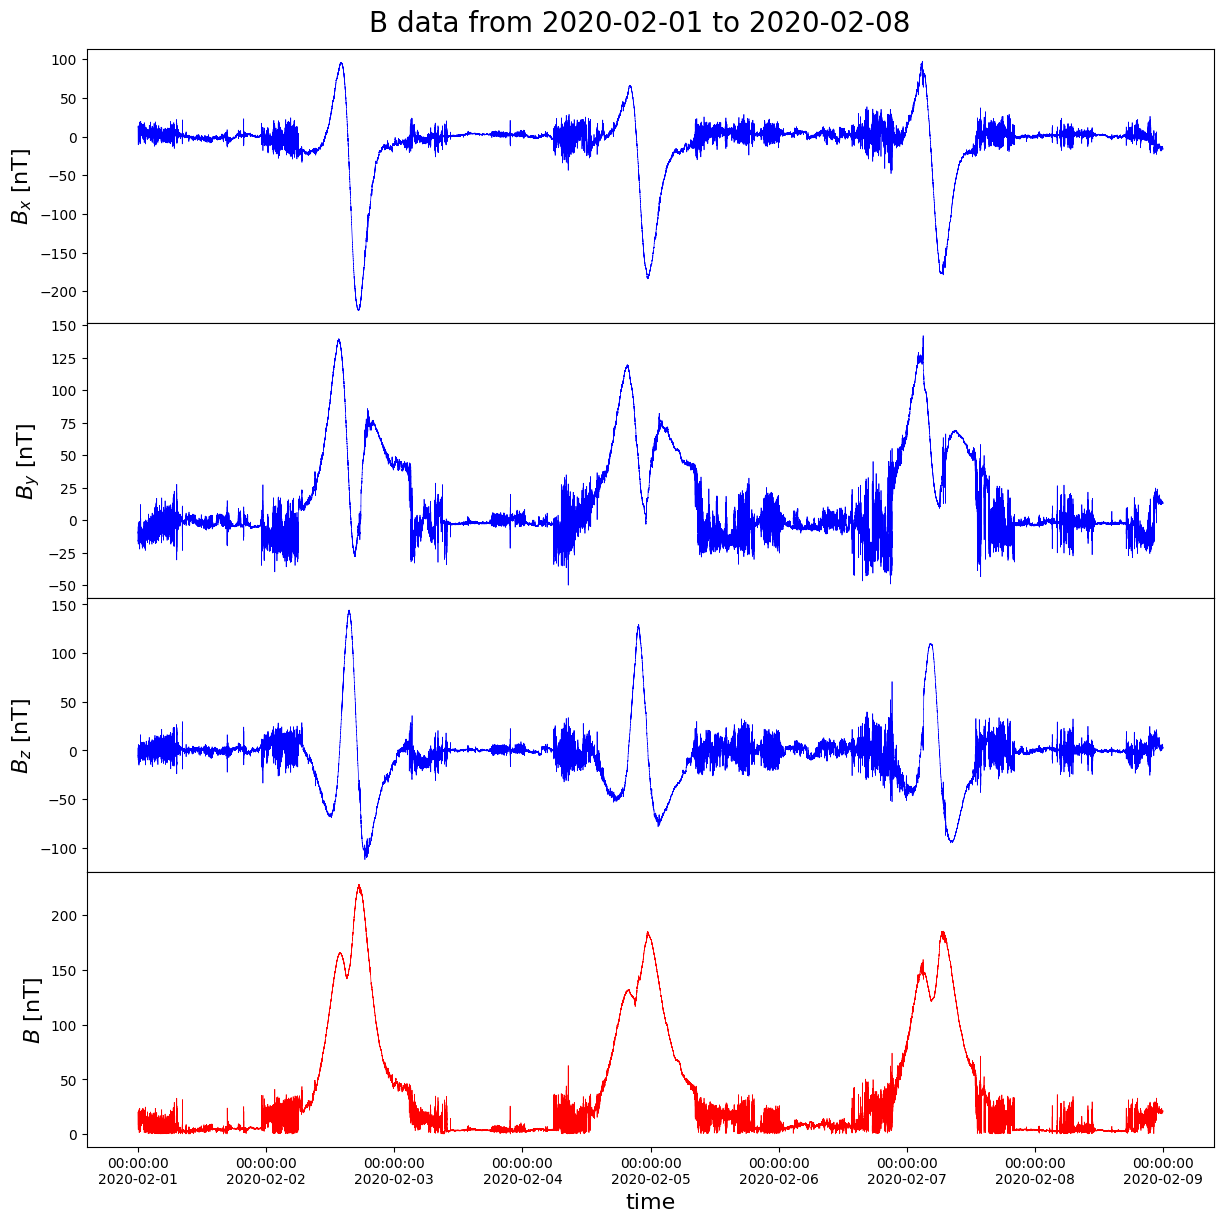

In [17]:
fig, axs = plt.subplots(4,  # 4 plots
                        figsize=(12,12), 
                        sharex=True, # share same x-range
                        sharey=False, # don't share same y-range
                        gridspec_kw={'hspace': 0})

fig.suptitle(f'B data from {start_date_str} to {end_date_str}', fontsize=20)

# Adjust the layout so that labels/titles don't overlap
plt.tight_layout()

# Plot B_x, B_y, and B_z against epoch on different axes
axs[0].plot(df_fgm['t'], df_fgm['B_x'], c='b', lw=0.5)
axs[1].plot(df_fgm['t'], df_fgm['B_y'], c='b', lw=0.5)
axs[2].plot(df_fgm['t'], df_fgm['B_z'], c='b', lw=0.5)
axs[3].plot(df_fgm['t'], df_fgm['B_mag'], c='r', lw=0.5)

# Add labels and title
plt.xlabel(r'time', fontsize=16) # or axs[2].set_xlabel

# Format the x-axis to display full dates and times with more detail
# "Hour:Minute:Second // Year-Month-Day"
date_format = mdates.DateFormatter('%H:%M:%S\n%Y-%m-%d')
axs[2].xaxis.set_major_formatter(date_format)

axs[0].set_ylabel(r'$B_x$ [nT]', fontsize=16)
axs[1].set_ylabel(r'$B_y$ [nT]', fontsize=16)
axs[2].set_ylabel(r'$B_z$ [nT]', fontsize=16)
axs[3].set_ylabel(r'$B$ [nT]', fontsize=16);

#plt.savefig(f'{data_name} data on {data_date}.png',bbox_inches='tight')

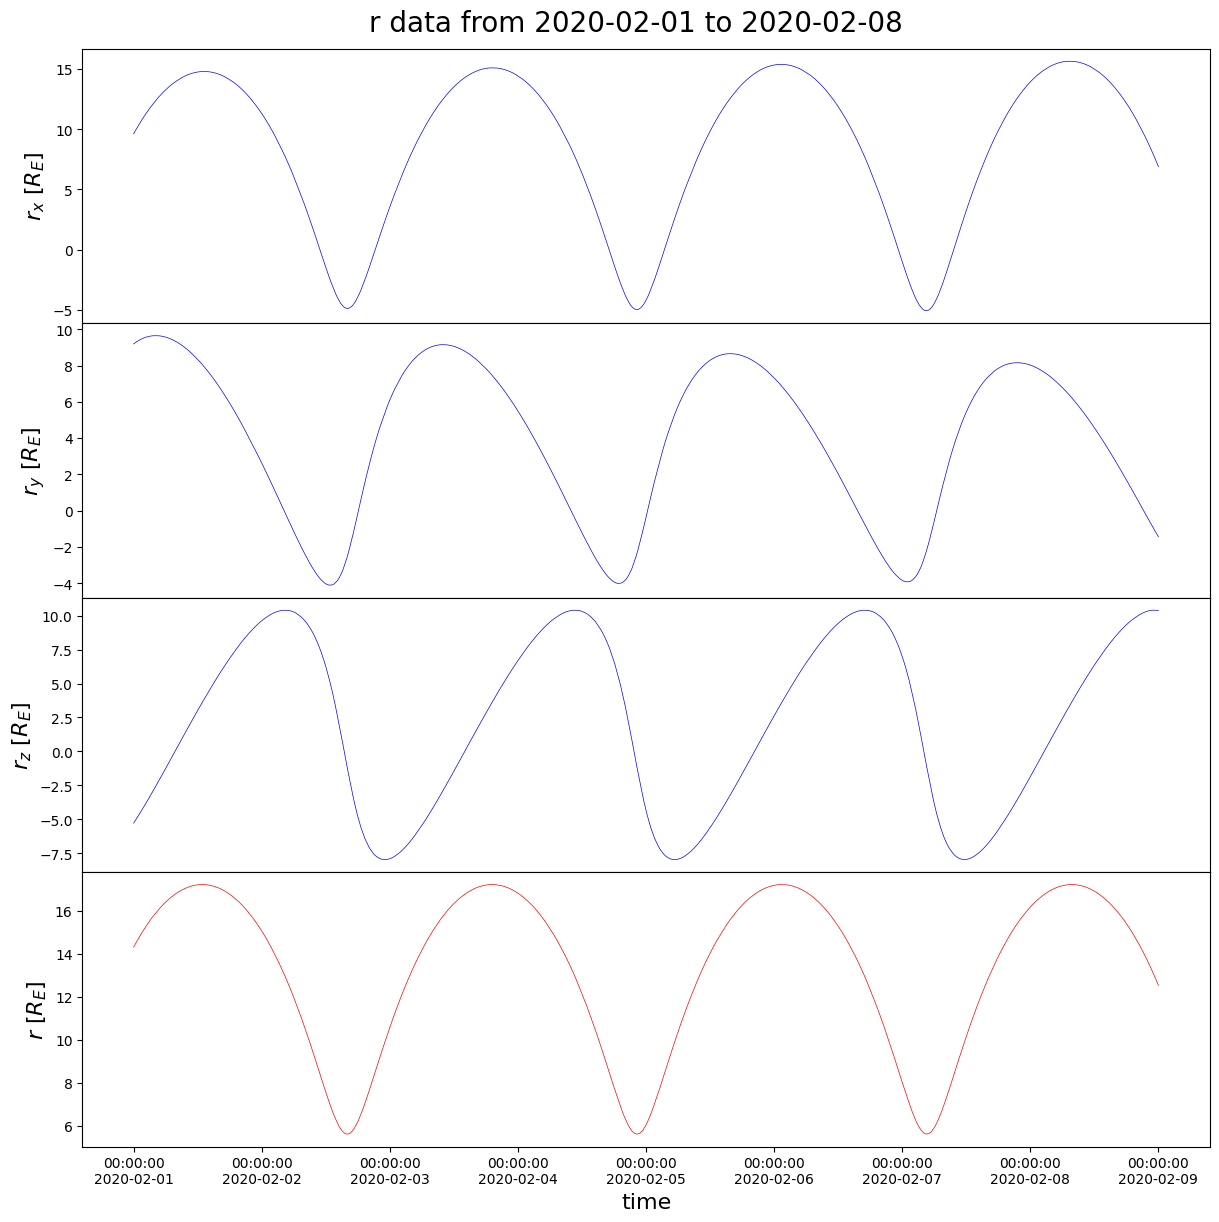

In [18]:
fig, axs = plt.subplots(4,  # 4 plots
                        figsize=(12,12), 
                        sharex=True, # share same x-range
                        sharey=False, # don't share same y-range
                        gridspec_kw={'hspace': 0})
fig.suptitle(f'r data from {start_date_str} to {end_date_str}', fontsize=20)

# Adjust the layout so that labels/titles don't overlap
plt.tight_layout()

# Plot r_x, r_y, and r_z against epoch on different axes
axs[0].plot(df_fgm['t'], df_fgm['r_x']/R_E, c='b', lw=0.5)
axs[1].plot(df_fgm['t'], df_fgm['r_y']/R_E, c='b', lw=0.5)
axs[2].plot(df_fgm['t'], df_fgm['r_z']/R_E, c='b', lw=0.5)
axs[3].plot(df_fgm['t'], df_fgm['r_mag']/R_E, c='r', lw=0.5)

# Add labels and title
plt.xlabel(r'time', fontsize=16) # or axs[2].set_xlabel

# Format the x-axis to display full dates and times with more detail
# "Hour:Minute:Second // Year-Month-Day"
date_format = mdates.DateFormatter('%H:%M:%S\n%Y-%m-%d')
axs[2].xaxis.set_major_formatter(date_format)

axs[0].set_ylabel(r'$r_x$ [$R_E$]', fontsize=16)
axs[1].set_ylabel(r'$r_y$ [$R_E$]', fontsize=16)
axs[2].set_ylabel(r'$r_z$ [$R_E$]', fontsize=16)
axs[3].set_ylabel(r'$r$ [$R_E$]', fontsize=16);

#plt.savefig(f'{data_name} data on {data_date}.png',bbox_inches='tight')

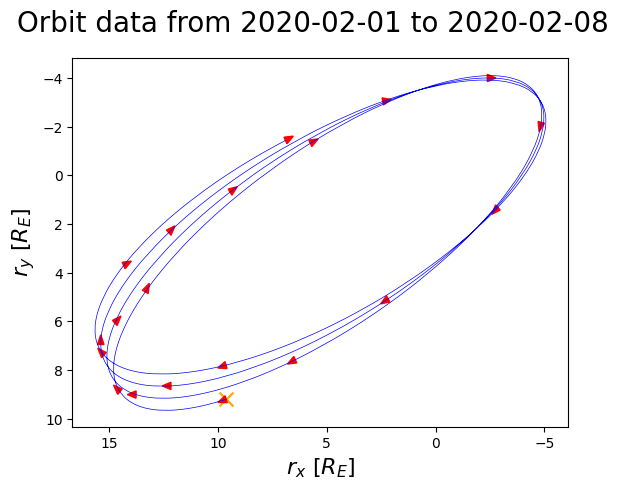

In [69]:
fig, ax = plt.subplots()
fig.suptitle(f'Orbit data from {start_date_str} to {end_date_str}', fontsize=20)

# Scaled to Earth radius
x = df_fgm['r_x']/R_E
y = df_fgm['r_y']/R_E

# Add small crosses at the start and end points
ax.scatter(x[0], y[0], color='orange', marker='x', s=100, label='Start Point')  # Start point

# Plot ry against rx to see orbit in x-y plane
ax.plot(x, y, c='b', lw=0.5)

# Add arrows to indicate direction
for i in np.linspace(50, len(x) - 2, 20):  # Adjust step for arrow density
    i=int(i)
    ax.arrow(x[i], y[i], x[i + 1] - x[i], y[i + 1] - y[i],
         head_width=.3, head_length=.4, fc='red', ec='red')

# Add labels and title
plt.xlabel(r'$r_x$ [$R_E$]', fontsize=16)
plt.gca().invert_xaxis()

plt.ylabel(r'$r_y$ [$R_E$]', fontsize=16)
plt.gca().invert_yaxis()

#plt.savefig(f'{data_name} data on {data_date}.png',bbox_inches='tight')